In [72]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import astropy.io.ascii as aa
import gzip
from matplotlib.colors import LogNorm
import pickle
import plotutils.plotutils as pu
import pystan
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [25]:
seaborn.set_style('ticks')

In [18]:
kois = aa.read('/Users/farr/Documents/Research/KepHackWeek/data/dr24_koi.csv')
kois

kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dicco_fra,koi_dicco_fra_err,koi_dicco_fdec,koi_dicco_fdec_err,koi_dicco_fsky,koi_dicco_fsky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_dikco_fra,koi_dikco_fra_err,koi_dikco_fdec,koi_dikco_fdec_err,koi_dikco_fsky,koi_dikco_fsky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype
int64,str9,str14,float64,float64,str12,float64,float64,str12,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,str15,str4,float64,str14,str14,int64,int64,float64,float64,int64,str33,float64,float64,float64,float64,str34,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str225,str10,int64,str15,str64,str15,str15,float64,float64,float64,str60,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,str4
7697568,K01829.01,--,296.52243,0.0,19h46m05.38s,43.363369,0.0,+43d21m48.1s,16.591,--,15.841,--,15.62,--,15.448,--,14.437,0.029,14.033,0.031,13.865,0.049,15.911,--,q1_q17_dr24_koi,Done,1.11111111111e+30,CANDIDATE,CANDIDATE,2,57,12.036085,50.30746,--,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2223,0.4689,Mandel and Agol (2002 ApJ 580 171),60.5,--,--,138.63416,0.00119,-0.00119,0,--,--,--,--,--,23.37,8.48,-1.93,0.1499,--,--,1.1845,0.5157,-0.1152,2.6837,0.0633,-0.0633,--,--,--,3390.3,71.2,-71.2,22.84151055,3.352e-05,-3.352e-05,0.260388,0.504439,-0.100065,28.03,6.5,-6.5,87.66,--,--,556.

In [13]:
pbins = loadtxt('pbins.dat.gz')
rbins = loadtxt('rbins.dat.gz')

In [15]:
geff = loadtxt('g-integrated-eff.dat.gz')
gids = geff[:,0]
geff = geff[:,1:].reshape((geff.shape[0], pbins.shape[0]-1, rbins.shape[0]-1))
gids = set([int(round(gid)) for gid in gids])

In [29]:
candidates = kois[kois['koi_pdisposition']=='CANDIDATE']
candidates = candidates[candidates['koi_max_mult_ev'] > 15]
candidates = candidates[(candidates['koi_period'] >= pbins[0]) & (candidates['koi_period'] < pbins[-1])]

In [52]:
pobs = []
robs = []
drobs = []
for c in candidates:
    if c['kepid'] in gids:
        pobs.append(c['koi_period'])
        robs.append(c['koi_prad'])
        drobs.append(c['koi_prad_err1'] - c['koi_prad_err2'])
pobs = array(pobs)
robs = array(robs)
drobs = array(drobs)
sel = (~np.isnan(pobs)) & (~np.isnan(robs)) & (~np.isnan(drobs))
pobs = pobs[sel]
robs = robs[sel]
drobs = drobs[sel]
sel = (pobs > 0) & (robs > 0) & (drobs > 0)
pobs = pobs[sel]
robs = robs[sel]
drobs = drobs[sel]

In [53]:
rmin = 0.0
rmax = 100.0

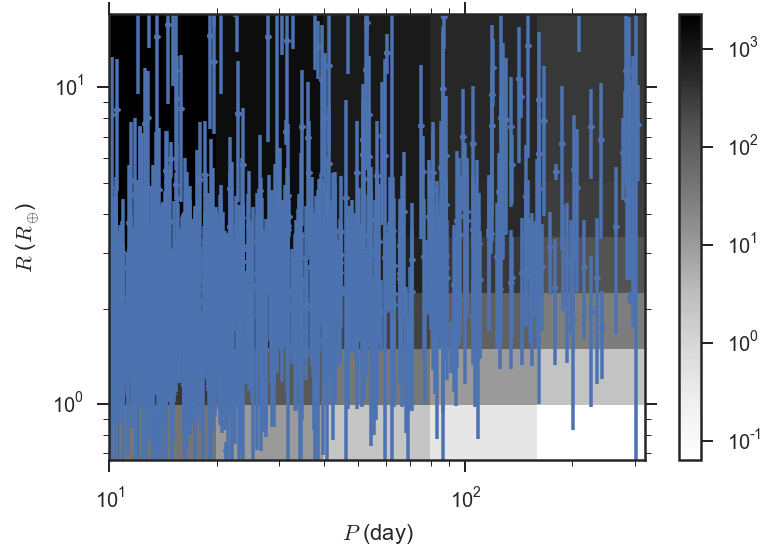

In [54]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, sum(geff, axis=0), norm=LogNorm())
errorbar(pobs, robs, drobs, fmt='.')
colorbar()
xscale('log')
yscale('log')
axis(xmin=pbins[0], xmax=pbins[-1], ymin=rbins[0], ymax=rbins[-1])
xlabel(r'$P$ (day)')
ylabel(r'$R$ ($R_\oplus$)')

In [62]:
data = {'nobs': robs.shape[0],
        'nps': pbins.shape[0]-1,
        'nrs': rbins.shape[0]-1,
        'pbins': pbins,
        'rbins': rbins,
        'pobs': pobs,
        'robs': robs,
        'drobs': drobs,
        'alphas': sum(geff, axis=0),
        'rmin': 0.01,
        'rmax': 100.0}

In [63]:
fit = pystan.stan(file='binned.stan', data=data)

/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled 

In [64]:
fit

Inference for Stan model: anon_model_5dd8be107406a9cca0ef3c3196cad1cd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rawrate[0,0]     -2.17    0.03   1.16  -4.73  -2.91  -2.08  -1.32  -0.25 1334.0    1.0
rawrate[1,0]      -1.1    0.04   1.37  -4.17  -1.94  -0.89  -0.07   0.98 1334.0    1.0
rawrate[2,0]     -1.22    0.04   1.57  -4.31  -2.32   -1.2-7.5e-3   1.53 1334.0    1.0
rawrate[3,0]     -1.67    0.04   1.39  -4.44   -2.6  -1.64  -0.71   0.96 1334.0    1.0
rawrate[4,0]     -1.61    0.04   1.44   -4.4  -2.58  -1.62  -0.66    1.2 1334.0    1.0
rawrate[0,1]      -2.5    0.03   1.06  -4.88  -3.12  -2.39  -1.76  -0.76 1334.0    1.0
rawrate[1,1]     -2.37    0.03   1.13  -4.84  -3.08  -2.28  -1.55  -0.46 1334.0    1.0
rawrate[2,1]     -1.12    0.03   1.12  -3.71  -1.72  -0.93  -0.31   0.53 1166.0    1.0
rawrate[3,1]     -1.83    0.

In [67]:
samples = fit.extract(permuted=True)
with gzip.open('stan-samples.pkl.gz', 'w') as out:
    pickle.dump(samples, out)

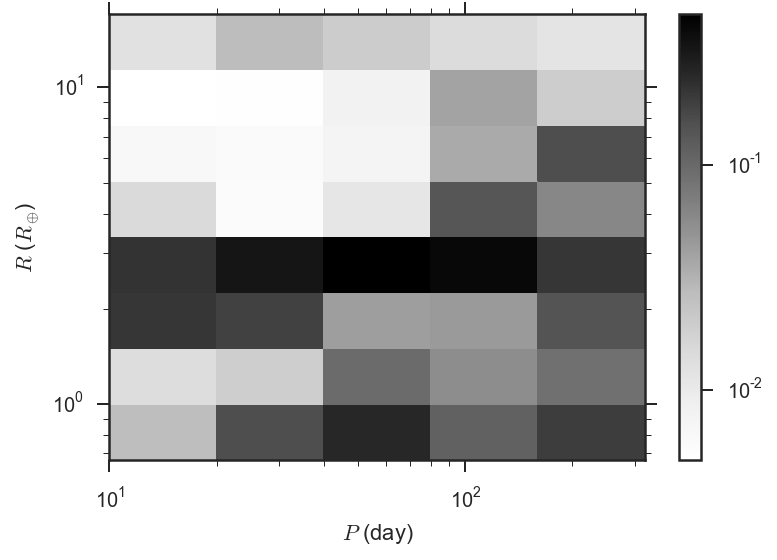

In [71]:
pcolormesh(PS, RS, mean(samples['dndlnpdlnr'], axis=0), norm=LogNorm())
colorbar()
xscale('log')
yscale('log')
axis(xmin=pbins[0], xmax=pbins[-1], ymin=rbins[0], ymax=rbins[-1])
xlabel(r'$P$ (day)')
ylabel(r'$R$ ($R_\oplus$)')

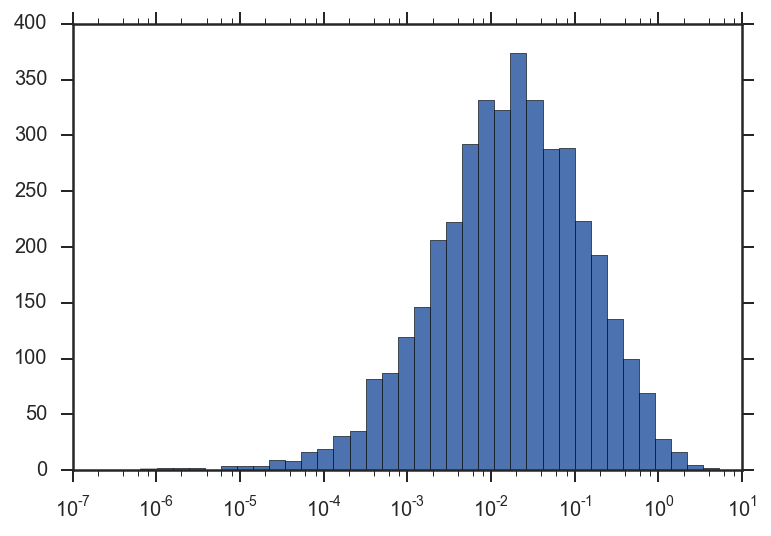

In [80]:
pu.plot_histogram_posterior(samples['dndlnpdlnr'][:,-1,1], log=True)

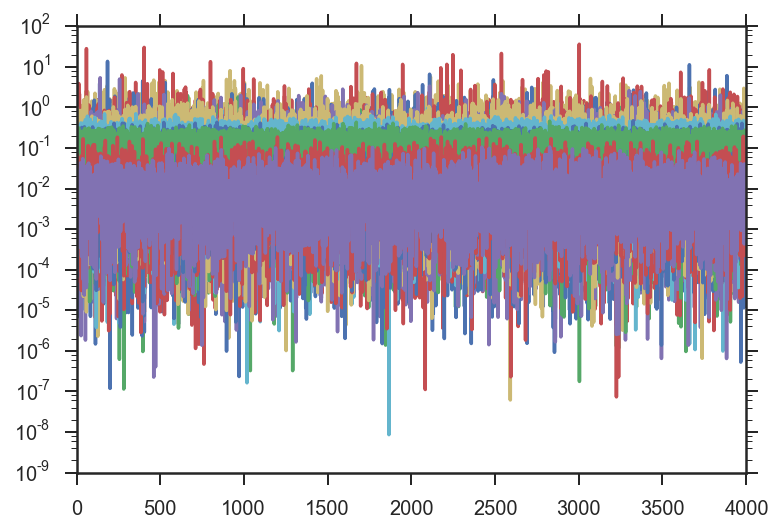

In [83]:
for i in range(pbins.shape[0]-1):
    for j in range(rbins.shape[0]-1):
        plot(samples['dndlnpdlnr'][:,i,j])
yscale('log')